<a href="https://colab.research.google.com/github/maheshyadav007/research/blob/main/Circle%20Exp%20Notebooks/NTK_infinite_width_circle_experiment_all_epochs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install torchviz

In [ ]:
import numpy as np
import pandas as pd

import pickle
import matplotlib.pyplot as plt
import matplotlib


import random
import os
import copy
import torch 
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from sklearn.model_selection import train_test_split 
import seaborn as sns
#from torchviz import make_dot
from google.colab import files
from scipy.linalg import eigh

# %matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
%matplotlib inline
# matplotlib.use('agg')

In [ ]:
import numpy as np 
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

**Input Generation**

In [ ]:
def set_seed(seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  # Python RNG
  np.random.seed(seed)
  random.seed(seed)

In [ ]:
# angles = np.arange(0,2*np.pi, 0.01)

# x=np.zeros((len(angles),2))
# y=np.zeros(len(angles))

# a=1 # Number of half cycles in the top half of the circle
# b=17 # number of half cycles in the bottom half of the circle

# for idx, angle in enumerate(angles):
#     x[idx,0]=np.cos(angle)
#     x[idx,1]=np.sin(angle)
#     if angle<np.pi:
#         y[idx] = np.sin(a*angle)
#     else:
#         y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

# # plt.plot(np.concatenate((angles,angles+np.pi*2)),np.concatenate((y,y)))
# plt.plot(angles, y)
# plt.figure()
# plt.axis('equal')
# plt.scatter(x[:,0],x[:,1],c=y)

In [ ]:

# delta = 10*np.pi/180
# point_x1 = 30*np.pi/180
# point_x2 = point_x1 + delta 
# point_x3 = 280*np.pi/180
# point_x4 = point_x3 + delta 

# plt.scatter(x1, x2, c = Y)

In [ ]:
class CustomDataset(Dataset):
      def __init__(self, X, Y):
          self.size = len(Y)
          self.x = torch.tensor(X)
          self.y = torch.tensor(Y)

      def __len__(self):
          return (self.size)

      def __getitem__(self, idx):
          #print(self.x[idx].shape,self.y[idx].shape )
          return self.x[idx].float(), self.y[idx].float()

def make_circle_dataset(n_data_points, a, b, plot = False):
  n_data_points = n_data_points
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)

  x=np.zeros((len(angles),2))
  y=np.zeros(len(angles))

  a=a # Number of half cycles in the top half of the circle
  b=b # number of half cycles in the bottom half of the circle

  for idx, angle in enumerate(angles):
      x[idx,0]=np.cos(angle)
      x[idx,1]=np.sin(angle)
      if angle<np.pi:
          y[idx] = np.sin(a*angle)
      else:
          y[idx] = np.sin(a*np.pi+b*(angle-np.pi))   

  # plt.plot(np.concatenate((angles,angles+np.pi*2)),np.concatenate((y,y)))
  
  if plot:
    plt.plot(angles, y)
    plt.figure()
    plt.axis('equal')
    plt.scatter(x[:,0],x[:,1],c=y)
  return x,y

def get_sorted_circle_dataset(X,Y):

  angles = [angle + 2*np.pi if angle < 0 else angle for angle in np.arctan2(X[:,1],X[:,0]) ]

  sorted_arg = np.argsort(angles)
  X_sorted = X[sorted_arg]
  Y_sorted = Y[sorted_arg]
  Y_sorted = Y_sorted.reshape((len(Y_sorted),1))
  return X_sorted, Y_sorted

def get_dataloaders(X,Y):
  batch_size = 32
  Y = Y.reshape((len(Y),1))
  # X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42, shuffle = True)
  train_dataloader = DataLoader(CustomDataset(X,Y), batch_size = batch_size, shuffle = True)
  # test_dataloader = DataLoader(CustomDataset(X_test, y_test), batch_size = batch_size, shuffle = True)
  dataloader_all = DataLoader(CustomDataset(X,Y), batch_size = len(Y), shuffle = False)
  return train_dataloader, dataloader_all
def get_stochastic_dataloader(X, Y):
  dl_one = DataLoader(CustomDataset(X,Y), batch_size = 1, shuffle = False)
  return dl_one

def plot_dataset(X_sorted, Y_sorted, points_idxs, save_fig):
  n_data_points = len(X_sorted)
  angles = np.arange(0,2*np.pi,2*np.pi/n_data_points)
  f, axes = plt.subplots(1,2, figsize = (2*5,5))
  axes[0].plot(angles, Y_sorted)
  axes[0].set_xlabel("angle in radians")
  axes[0].axis('equal')
  axes[1].scatter(X_sorted[:,0],X_sorted[:,1],c=Y_sorted)
  
  for i, point in enumerate(points_idxs):
    axes[1].scatter(X_sorted[point,0],X_sorted[point,1], c = 'r')
    axes[1].annotate(f'x{i+1}', (X_sorted[point,0],X_sorted[point,1]), xytext = (X_sorted[point,0]-.15,X_sorted[point,1]) )
  if save_fig:
    plt.savefig('input_dataset')

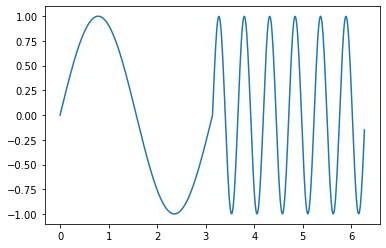

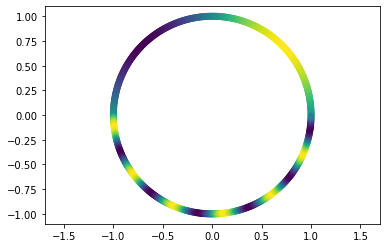

In [ ]:
_,_ = make_circle_dataset(500, 2, 12, plot = True)

In [ ]:

# def find_nearest(array, value):
#     array = np.asarray(array)
#     idx = (np.abs(array - value)).argmin()
#     return idx

# temp = np.array(np.sort(np.arctan2(X[:,1],X[:,0])*180/np.pi), dtype = int)
# value1 = -100
# x1_idx = find_nearest(temp, value1)
# x2_idx = find_nearest(temp, value1+10)

# value2 = 70
# x3_idx = find_nearest(temp, value1)
# x4_idx = find_nearest(temp, value1+10)

**MLP**

In [ ]:

# intermediate_outs_run.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
# predictions_run.append(prediction)
# # print(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
# kernels = get_kernels(hidden_layer_outputs)
# # YKYs =  YKYs = get_YKYs(kernels)
# model_learning_status = "Learned"
# # state_info["Y'KY"] = YKYs
# state_info["step"] = batch+1
# state_info["Run"] = str(run)
# state_info["epoch"] = "{:03}".format(epoch)
# state_info["loss"] = float("{:.3f}".format(loss))
# state_info["model_learning_status"] = "Learned"
# kernels_over_batches.append(kernels)
# state_info_over_batches.append(state_info.copy())

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self, n_hidden_layers, n_neurons, protocol_type, bias):
        super(NeuralNet, self).__init__()
        
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.bias = bias
        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons, bias = self.bias).to(device)])
        
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons, bias = self.bias).to(device))

        self.layers.append(nn.Linear( self.n_neurons, 1, bias = self.bias).to(device))
  def forward(self, x, batch = None):
        hidden_layer_outputs = []
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          out = torch.relu(x)
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[-1](x)
        return x, hidden_layer_outputs
        

**Visualizing Kernels for MLP**

In [ ]:
def plot_heatmap(K, YKYs, state_info, all_input = True, save_fig = True, show_fig = False):
  # plt.figure(figsize = (15,500))
  f, axes = plt.subplots(1, len(K),figsize = (4,3))
  if len(K) == 1:
    axes = [axes]
  for i in range(len(K)):
    if all_input:
      ax = sns.heatmap(K[i][0:500:5,0:500:5], linewidth=0, ax = axes[i])
    else:
      ax =sns.heatmap(K[i][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]], linewidth=.2, ax = axes[i])
    
    model_title = state_info["model_protocol_type"] +'(' + 'n_h_l = '+ str(state_info["n_hidden_layers"])+ ', n_n = '+ str(state_info["n_neurons"])+','+ 'Run=' + str(state_info["run"])+',' +'Epoch = '+str(state_info['epoch'])+','+'step='+ str(state_info['step']) +',' +state_info['learning_status']+ ','+ "loss = " + str(state_info['loss'])   +')'
    if i < len(K)-1:
      title = 'K'+str(i+1)+ ', ' +"Y'KY_n = "+ YKYs[i] 
      ax.set_xlabel(title, fontsize = 10)
      pass
    else:
      title = 'NTK'+', ' +"Y'KY_n = "+  YKYs[i] 
      ax.set_xlabel(title, fontsize = 10)

  plt.suptitle(model_title,x = 0.5, y = 1.05,ha = 'center', fontsize = 8, fontweight = 2)
  if save_fig:
    plt.savefig(model_title + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  if show_fig:
    plt.show()  
  plt.clf()
  plt.close(f)

In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def get_4_inp_idxs(X_sorted, point1_degrees = 40, point2_degrees = 300, diff_in_degrees = 10):

  temp = np.array([(angle + 2*np.pi)*180/np.pi if angle < 0 else angle*180/np.pi for angle in np.arctan2(X_sorted[:,1],X_sorted[:,0]) ], dtype = int)
  value1 = point1_degrees
  x1_idx = find_nearest(temp, value1)
  x2_idx = find_nearest(temp, value1+diff_in_degrees)

  value2 = point2_degrees
  x3_idx = find_nearest(temp, value2)
  x4_idx = find_nearest(temp, value2+diff_in_degrees)
  return x1_idx, x2_idx, x3_idx, x4_idx


In [ ]:

def format_state_info(state_info):
  state_info["run"] = str(state_info["run"])
  state_info["epoch"] = f'{int(state_info["epoch"]):03d}'
  state_info["step"] = f'{int(state_info["step"]):02d}'
  state_info["loss"] = float("{:.3f}".format(state_info["loss"]))
  state_info["learning_status"] = state_info["learning_status"]
  return state_info


def routine(hidden_layer_outs_container, state_info_container, predictions_container,gradients_container,  hidden_layer_outputs,state_info, predictions, gradients):

  # hidden_layer_outs_container.append(hidden_layer_outputs)
  # state_info_container.append(copy.deepcopy(state_info))
  # predictions_container.append(predictions)
  # gradients_container.append(gradients)

  #-------

  kernel_5_runs = build_neural_tangent_kernels([[gradients]])
  # for kernel_name in ['NTK']:
  #   plot_kernel_values_stepwise(kernel_name,kernel_5_runs )
  #   plot_kernel_values_epochwise(kernel_name,kernel_5_runs )

  # plot_stepwise_activations(hidden_layer_no =2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
  # plot_epochwise_activations(hidden_layer_no = 2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
  # plot_stepwise_loss(state_info_5_runs)
  # plot_epochwise_loss(state_info_5_runs)
  plot_kernels(kernel_5_runs, [[state_info]],for_all_inputs = True, save_fig = True, show_fig = True)
 

In [ ]:
def compute_pred_gradient(dl_one,model, optimizer):
  all_per_sample_gradients = []
  for b, b_d in enumerate(dl_one):
    x, y = b_d[0], b_d[1]
    X, y = x.to(device), y.to(device)
    if type(model) == list:
      h_l_o = model[0](X.float())
      pred, _ = model[1](X.float(), h_l_o)
      pred.backward(retain_graph=False)
      per_sample_gradients_npf = np.concatenate([p.grad.flatten().detach().clone().to('cpu') for p in model[0].parameters()])
      per_sample_gradients_npv = np.concatenate([p.grad.flatten().detach().clone().to('cpu') for p in model[1].parameters()])
      per_sample_gradients = np.concatenate([per_sample_gradients_npf, per_sample_gradients_npv])
      
    else:
      pred, _ = model(X.float())
      pred.backward(retain_graph=False)
      per_sample_gradients = np.concatenate([p.grad.flatten().detach().clone().to('cpu') for p in model.parameters()])

    all_per_sample_gradients.append(per_sample_gradients)
    optimizer.zero_grad()
  return all_per_sample_gradients

In [ ]:


def train(dataloader, model, loss_fn, optimizer,  dataloader_all = None,dataloader_one = None, state_info = None):
    size = len(dataloader.dataset)
    correct = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []
    gradients_over_batches = []
    for batch, (x,y) in enumerate(dataloader):
        

        X, y = x.to(device), y.to(device)
        pred, _ = model(X.float())
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # loss = loss.item()
        if batch%15 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")

        optimizer.zero_grad()
        if int(state_info['epoch']) <= 2:
          all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = model, optimizer = optimizer)
          predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,model, loss_fn)
          state_info.update({'step' : batch+1})
          state_info.update({'loss' : loss})
          state_info = format_state_info(state_info)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches, gradients_container = gradients_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = [state_info], predictions = predictions, gradients = [all_per_sample_gradients]
            )
          del all_per_sample_gradients
          # plot_heatmap(kernels, state_info)

    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches, gradients_over_batches

def evaluate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    
    out = [x.clone().detach().to('cpu').numpy() for x in out]
    print(f"Loss over all Data : {test_loss:>4f} \n")
    return pred, out, test_loss

In [ ]:



# for n_h_l in [5]:
 
  # for n_n in [32]:
def run_mlp_model(train_dataloader, dataloader_all,dataloader_one, n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 100, bias = True):
    model_protocol_type = "MLP"
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    # kernel_5_runs = []
    
    # intermediate_outs_5_runs = []
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    gradients_5_runs = []
    # rand_kernels_over_5 = []
    for run in range(n_runs):

      
     

      #model init
      mlp_model = NeuralNet( n_hidden_layers, n_neurons, model_protocol_type, bias).to(device)
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam(mlp_model.parameters(),lr = 3e-3)  

      #Local variables init
      # model_learning_status = "UnLearned"
      # kernels_run = []
      hidden_layer_outs_run = []
      state_info_run = []
      predictions_run = []
      gradients_run = []
      epochs = n_epochs


      #Evaluate before training starts
      all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = mlp_model, optimizer = optimizer)
      predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,mlp_model, loss_fn)
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'loss' : loss,'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], gradients = [all_per_sample_gradients]
              )
      del all_per_sample_gradients
      # print(state_info_run)
      # hidden_layer_outs_run.append([hidden_layer_outputs])
      # state_info_run.append([state_info.copy()])
      # predictions_run.append([predictions])
      # print(state_info)
      # debug()
      #Store init result
      # kernels_run.append([kernels])
      # state_info_run.append([state_info.copy()])
      # intermediate_outs_run.append(np.array((hidden_layer_outputs[1][[x1_idx, x2_idx, x3_idx, x4_idx]]).detach().to('cpu')))
     

      for epoch in range(epochs):
          print(f"Epoch {epoch+1}\n-------------------------------")
          state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'loss' : loss,'learning_status' : 'Learned'})
          predictions_batches, hidden_layer_outs_batches, state_info_batches, gradients_batches = train(train_dataloader,mlp_model, loss_fn, optimizer,
                                                                                                            dataloader_all = dataloader_all,dataloader_one = dataloader_one, state_info = state_info)
          
          
          if int(state_info['epoch']) <= 2: 
            #mark
            # routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
            #         hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches, gradients = gradients_batches
            #         )
            pass
          # else:
          elif (int(state_info['epoch'])-1) % 10 == 0:
            all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = mlp_model, optimizer = optimizer)
            predictions, hidden_layer_outputs, loss = evaluate(dataloader_all,mlp_model, loss_fn)
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], gradients = [all_per_sample_gradients]
                    )
            # hidden_layer_outs_run.append([hidden_layer_outputs])
            # state_info_run.append([state_info.copy()])
            # predictions_run.append([predictions])

            

          # print(state_info_run)
            
          

    # intermediate_outs_5_runs.append(intermediate_outs_run)
    # kernel_5_runs.append(kernels_run)
      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)
      gradients_5_runs.append(gradients_run)
    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, gradients_5_runs

In [ ]:
class NPFNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons, protocol_type):
        super(NPFNeuralNetwork, self).__init__()
        self.protocol_type = protocol_type
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        
        self.layers = nn.ModuleList([])
   
        #For DLGN-SF, DGN-DLGN-SF
        if self.protocol_type == "DLGN-SF":
          self.layers.append(nn.Linear(2,  self.n_neurons, bias = True).to(device))
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( 2,  self.n_neurons, bias = True).to(device))
            
        elif self.protocol_type == "DGN-DLGN-SF":
          self.layers.append(nn.Sequential(nn.Linear(2,  self.n_neurons, bias = True).to(device),
                                            nn.ReLU(),
                                            nn.Linear(self.n_neurons,  self.n_neurons, bias = True).to(device)
                                            )
                            )
          
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Sequential(
                                  nn.Linear( 2,  self.n_neurons, bias = True).to(device),
                                  nn.ReLU(),
                                  nn.Linear(self.n_neurons,  self.n_neurons, bias = True).to(device)
                              )
                        )
        #For DGN, DLGN
        else: 
          self.layers.append(nn.Linear(2,  self.n_neurons, bias = True).to(device))
          for i in range(self.n_hidden_layers-1):
            self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
        
        
        
        # self.layers.append(nn.Linear( self.n_neurons, 1, bias = False).to(device))
  
        
    def forward(self, x):
        hidden_layer_outputs = []
      
        if self.protocol_type == "DGN":
          for i in range(len(self.layers)):
            x = self.layers[i](x)
            out = torch.relu(x)
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.protocol_type == "DLGN":
          for i in range(len(self.layers)):
            x = self.layers[i](x)
            out = x
            hidden_layer_outputs.append(out)
            x = out
          #x = self.layers[len(layers)-1](x)

        elif  self.protocol_type == "DLGN-SF":
          for i in range(len(self.layers)):
            out = self.layers[i](x)
            hidden_layer_outputs.append(out)
        elif  self.protocol_type == "DGN-DLGN-SF":
          for i in range(len(self.layers)):
            out = self.layers[i](x) 
            hidden_layer_outputs.append(out)
        

        return hidden_layer_outputs



class NPVNeuralNetwork(nn.Module):
    def __init__(self, n_hidden_layers, n_neurons):
        super(NPVNeuralNetwork, self).__init__()
  
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons

        self.layers = nn.ModuleList([nn.Linear(2,  self.n_neurons).to(device)])
      
        for i in range(self.n_hidden_layers-1):
          self.layers.append(nn.Linear( self.n_neurons,  self.n_neurons).to(device))
          
        self.layers.append(nn.Linear( self.n_neurons, 1).to(device))

        self.gate = Gate()
      
    def forward(self, x, gating_mask):
        hidden_layer_outputs = []
        for i in range(len(self.layers)-1):
          x = self.layers[i](x)
          
          out = self.gate(x, i, gating_mask)
          
          hidden_layer_outputs.append(out)
          x = out
        x = self.layers[len(self.layers)-1](x)
        #print("debug 2", x.shape, x)
        return x,  hidden_layer_outputs


def apply_gate(beta, idx, gating_mask):
  out = beta*(gating_mask[idx])
  
  return out
  
class Gate(nn.Module):
    def __init__(self, beta = 4):
        super(Gate,self).__init__()
        self.beta = beta

    def forward(self, x, idx, gating_mask):
      #Soft Relu
      return torch.mul(x,torch.sigmoid(apply_gate(self.beta, idx,gating_mask)))

      #Hard Relu
      #return torch.mul(x,torch.sign(gating_mask[idx]))



def train_decoupled(X1_dataloader,X2_dataloader, npf_model, npv_model, loss_fn, optimizer, dataloader_all = None, dataloader_one = None, state_info = None):
    size = len(X1_dataloader.dataset)
    correct = 0
    state_info_over_batches = []
    hidden_layer_outs_over_batches = []
    predictions_over_batches = []
    gradients_over_batches = []
    for batch, ((X1, y1), (X2,y2)) in enumerate(zip(X1_dataloader, X2_dataloader)):
        X1, y1 = X1.to(device), y1.to(device)
        X2, y2 = X2.to(device), y2.to(device)
        
        npf_model_hidden_layer_outs = npf_model(X1)
        pred, npv_model_hidden_layer_outs = npv_model(X2, npf_model_hidden_layer_outs)
        #print("Debug1 ", pred.shape)
        loss = loss_fn(pred, y1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch%10 == 0:
        #     #correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        #     loss, current = loss.item(), batch * len(X1)
        #     print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
        if int(state_info['epoch']) <= 2:
          all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = [npf_model,npv_model], optimizer = optimizer)
          predictions, hidden_layer_outputs, loss = evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
          state_info.update({'step' : batch+1})
          state_info.update({'loss' : loss})
          state_info = format_state_info(state_info)
          routine(hidden_layer_outs_container = hidden_layer_outs_over_batches, state_info_container = state_info_over_batches, predictions_container = predictions_over_batches, gradients_container = gradients_over_batches,
            hidden_layer_outputs = hidden_layer_outputs, state_info = [state_info], predictions = predictions, gradients = [all_per_sample_gradients]
            )
          del all_per_sample_gradients
    return predictions_over_batches, hidden_layer_outs_over_batches, state_info_over_batches, gradients_over_batches

def evaluate_decoupled(dataloader, npf_model, npv_model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    npf_model.eval()
    npv_model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            npf_model_hidden_layer_outs = npf_model(X)
            pred, npv_model_hidden_layer_outs = npv_model(X, npf_model_hidden_layer_outs)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    npf_model_hidden_layer_outs = [x.clone().detach().to('cpu').numpy() for x in npf_model_hidden_layer_outs]
    print(f"Loss over all data : {test_loss:>5f} \n")
    return pred, npf_model_hidden_layer_outs, test_loss



In [ ]:


def run_npf_npv_model(train_dataloader, dataloader_all,dataloader_one, protocol = 'DGN', n_h_l = 5,n_n = 32, n_runs = 5, n_epochs = 250):

    model_protocol_type = protocol
    n_hidden_layers = n_h_l
    n_neurons = n_n

    state_info = {"model_protocol_type" : model_protocol_type,"n_hidden_layers":n_hidden_layers, "n_neurons" : n_neurons}
    hidden_layer_outs_5_runs = []
    state_info_5_runs = []
    predictions_5_runs = []
    gradients_5_runs = []
    for run in range(n_runs):
      
      #Model Init
      npf_model = NPFNeuralNetwork(n_hidden_layers, n_neurons, model_protocol_type).to(device)
      npv_model = NPVNeuralNetwork(n_hidden_layers, n_neurons).to(device)
      loss_fn = nn.MSELoss()
      optimizer = torch.optim.Adam([
                      {'params': npf_model.parameters()},
                      {'params': npv_model.parameters()}],
                      lr = 3e-3) 
      # optimizer = torch.optim.Adam([
      #                 {'params': npv_model.parameters()}],
      #                 lr = 3e-3) 
      #Make the non linear layer of NPF model untrainable
      #NOTE: Unchecked for different hidden layers(Currently working for n_h_l = 5)
      if model_protocol_type == 'DGN-DLGN-SF':
        for idx, param in enumerate(npf_model.parameters()):
          if idx % 4 == 0 or idx-1 % 4 == 0:
            param.requires_grad = False
      
      #Local Variable Init
      hidden_layer_outs_run = []
      state_info_run = []
      predictions_run = []
      gradients_run = []
      epochs = n_epochs

      #Evaluate before training starts
      all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = [npf_model,npv_model], optimizer = optimizer)
      predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
      state_info.update({'run' : run+1, 'epoch' : 0,'step' : 0,'loss' : loss,'learning_status' : 'UnLearned'})
      state_info = format_state_info(state_info)
      routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
              hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], gradients = [all_per_sample_gradients]
              )
      del all_per_sample_gradients
      for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : None,'loss' : loss,'learning_status' : 'Learned'})
        predictions_batches, hidden_layer_outs_batches, state_info_batches, gradients_batches  = train_decoupled(train_dataloader,train_dataloader,npf_model, npv_model, loss_fn, optimizer,
                                                                  dataloader_all = dataloader_all,dataloader_one = dataloader_one, state_info = state_info)
        

        if int(state_info['epoch']) <= 2: 
            # routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
            #         hidden_layer_outputs = hidden_layer_outs_batches, state_info = state_info_batches, predictions = predictions_batches, gradients = gradients_batches
            #         )
            pass
        # else:
        elif (int(state_info['epoch'])-1) % 10 == 0: #int(state_info['epoch']) > 2:
            all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = [npf_model,npv_model], optimizer = optimizer)
            predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
            state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
            state_info = format_state_info(state_info)
            routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
                    hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], gradients = [all_per_sample_gradients]
                    )
        # elif int(int(state_info['epoch']) % 30) == 0: #int(state_info['epoch']) > 2:

        #     all_per_sample_gradients = compute_pred_gradient(dl_one = dataloader_one,model = [npf_model,npv_model], optimizer = optimizer)
        #     predictions, hidden_layer_outputs, loss =  evaluate_decoupled(dataloader_all,npf_model, npv_model, loss_fn)
        #     state_info.update({'run' : run+1, 'epoch' : epoch+1,'step' : 16,'loss' : loss,'learning_status' : 'Learned'})
        #     state_info = format_state_info(state_info)
        #     routine(hidden_layer_outs_container = hidden_layer_outs_run, state_info_container = state_info_run, predictions_container = predictions_run, gradients_container = gradients_run,
        #             hidden_layer_outputs = [hidden_layer_outputs], state_info = [state_info], predictions = [predictions], gradients = [all_per_sample_gradients]
        #             )



      state_info_5_runs.append(state_info_run)
      hidden_layer_outs_5_runs.append(hidden_layer_outs_run)
      predictions_5_runs.append(predictions_run)
      gradients_5_runs.append(gradients_run)
    return hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, gradients_5_runs
    

In [ ]:
#-------------------------------------------------------Plotting Functions--------------------------------------------------------

#For step wise analysis
def plot_kernel_values_stepwise(kernel_name, kernel_5_runs):
  kernel_map = {'NTK':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  kernel_idx = kernel_map[kernel_name]

  f, axes = plt.subplots(1, len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]
  for run in range(len(kernel_5_runs)):
    values = [[],[],[],[],[],[]]
    for epoch in range(len(kernel_5_runs[run])):
      for step in range(len(kernel_5_runs[run][epoch])):
        sub_kernel= kernel_5_runs[run][epoch][step][kernel_idx][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]]
        values[0].append(sub_kernel[0][0])
        values[1].append(sub_kernel[1][1])
        values[2].append(sub_kernel[2][2])
        values[3].append(sub_kernel[3][3])
        values[4].append(sub_kernel[0][1])
        values[5].append(sub_kernel[2][3])
      if epoch == 2:
        break
    values = np.array(values)   
    plt.suptitle(f'{kernel_name}_step',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(values[i], label=labels[i])
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)
      axes[run].legend(loc='best')

  plt.savefig(f'{kernel_name}_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

#For epoch wise analysis
def plot_kernel_values_epochwise(kernel_name, kernel_5_runs):
  kernel_map = {'NTK':0, 'K2':1, 'K3':2,'K4':3, 'K5':4, 'K': 5}
  labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
  kernel_idx = kernel_map[kernel_name]

  f, axes = plt.subplots(1, len(kernel_5_runs),figsize = (7*len(kernel_5_runs), 7))
  if len(kernel_5_runs) == 1:
    axes = [axes]
  for run in range(len(kernel_5_runs)):
    values = [[],[],[],[],[],[]]
    for epoch in range(len(kernel_5_runs[run])):
        sub_kernel = kernel_5_runs[run][epoch][-1][kernel_idx][[x1_idx, x2_idx, x3_idx, x4_idx]][:,[x1_idx, x2_idx, x3_idx, x4_idx]]
        values[0].append(sub_kernel[0][0])
        values[1].append(sub_kernel[1][1])
        values[2].append(sub_kernel[2][2])
        values[3].append(sub_kernel[3][3])
        values[4].append(sub_kernel[0][1])
        values[5].append(sub_kernel[2][3])

    values = np.array(values)
    plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(values[i], label=labels[i])
      axes[run].set_xlabel(f'Run {run+1}', fontsize = 12)
      axes[run].legend(loc='best')

  plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

  # Plot Activation graph stepwise
def plot_stepwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''
  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')
  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
      for step in range(len(hidden_layer_outs_5_runs[run][epoch])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][step][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]#[:,[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      if epoch == 2:
        break
   
    values = np.array(values)
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      axes[i].set_xlabel(f'Step', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      axes[i].set_xticks(np.arange(0,len(values), 1.0))
      for j in range(NUM_COLORS):

        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_step.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

# Plot Activation graph epochwise
def plot_epochwise_activations(hidden_layer_no, hidden_layer_outs_5_runs):
  temp = []
  y_label = ''
  NUM_COLORS = n_neurons
  LINE_STYLES = ['solid', 'dashed', 'dashdot', 'dotted']
  NUM_STYLES = len(LINE_STYLES)
  cm = plt.get_cmap('gist_rainbow')
  hidden_layer_no = hidden_layer_no
  for run in range(len(hidden_layer_outs_5_runs)):
    f, axes = plt.subplots(1, 4,figsize = (7*5,7))
    values = []
    for epoch in range(len(hidden_layer_outs_5_runs[run])):
        sub_h_l_outs = hidden_layer_outs_5_runs[run][epoch][-1][hidden_layer_no-1][[x1_idx, x2_idx, x3_idx, x4_idx]]
        values.append(sub_h_l_outs)
      
    values = np.array(values)
    plt.suptitle(f'Run {run+1} for Hidden Layer No. {hidden_layer_no}',ha = 'center', fontsize = 15)
    for i in range(4):
      lines = axes[i].plot(values[:][:,i])
      axes[i].set_title(f'x_{i+1}')
      axes[i].set_xlabel(f'Epoch', fontsize = 12)
      axes[i].set_ylabel(y_label, fontsize = 12)
      axes[i].set_xticks(np.arange(0,len(values), 10.0))
      for j in range(NUM_COLORS):

        lines[j].set_color(cm(j//NUM_STYLES*float(NUM_STYLES)/NUM_COLORS))
        lines[j].set_linestyle(LINE_STYLES[j%NUM_STYLES])
    plt.savefig(f'Run_{run+1}_epoch.png',format = "png",bbox_inches='tight', dpi = 100)
    plt.show()


#For step wise loss analysis
def plot_stepwise_loss(state_info_5_runs):
  f, axes = plt.subplots(1, 5,figsize = (7*5,7))
  for run in range(len(state_info_5_runs)):
    values = []
    for epoch in range(len(state_info_5_runs[run])):
      for step in range(len(state_info_5_runs[run][epoch])):
        loss = state_info_5_runs[run][epoch][step]['loss']
        values.append(loss)
      if epoch == 2:
        break
    values = np.array(values)
    
    plt.suptitle('Loss v/s step',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(values)
      axes[run].set_title(f'Run {run+1}')
      axes[run].set_xlabel(f'Step', fontsize = 12)
      axes[run].set_ylabel(f'Loss', fontsize = 12)
      axes[run].set_xticks(np.arange(0,len(values), 2.0))
      

  plt.savefig('loss_step' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()

# For epoch wise loss analysis
def plot_epochwise_loss(state_info_5_runs):
  f, axes = plt.subplots(1, 5,figsize = (7*5,7))
  for run in range(len(state_info_5_runs)):
    values = []
    for epoch in range(len(state_info_5_runs[run])):
      loss = state_info_5_runs[run][epoch][-1]['loss']
      values.append(loss)
      
    values = np.array(values)
    
    plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 15)
    for i in range(len(values)):
      axes[run].plot(values)
      axes[run].set_title(f'Run {run+1}')
      axes[run].set_xlabel(f'Epoch', fontsize = 12)
      axes[run].set_ylabel(f'Loss', fontsize = 12)
      axes[run].set_xticks(np.arange(0,len(values), 10.0))

  plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
  plt.show()



In [ ]:
def get_YKYs(kernels):
  YKYs = []
  for i in range(len(kernels)):
    YKY = np.matmul(np.matmul(Y_sorted.T, kernels[i]), Y_sorted)
    eigen_vals = eigh(kernels[i], eigvals_only = True)
    YKYs.append(str(round(YKY[0][0]/eigen_vals[-1], 2)))
  return YKYs
def get_kernels(grad):
  np_grad = np.array(grad)
  NTK = np.matmul(np_grad, np_grad.T)
  eigen_vals = eigh(NTK, eigvals_only = True)
  NTK = NTK/eigen_vals[-1]
  return [NTK]

def build_neural_tangent_kernels(gradients_5_runs):
  grads = gradients_5_runs
  kernel_5_runs = []
  for run in range(len(grads)):
      kernel_epochs = []
      for epoch in range(len(grads[run])):
        kernel_step = []
        for step in range(len(grads[run][epoch])):
          NTK = get_kernels(grads[run][epoch][step])
          kernel_step.append(NTK)
        kernel_epochs.append(kernel_step)
      kernel_5_runs.append(kernel_epochs)
  return kernel_5_runs

def plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False):

  s_i = state_info_5_runs
  for run in range(1):
    for epoch in range(len(kernel_5_runs[run])):
      for step in range(len(kernel_5_runs[run][epoch])):
        kernels = kernel_5_runs[run][epoch][step]
        YKYs = get_YKYs(kernels)
        plot_heatmap(kernels,YKYs, s_i[run][epoch][step], all_input = for_all_inputs, save_fig = save_fig, show_fig = show_fig)
      if (not for_all_inputs) and epoch == 2:
        print(run, epoch)
        break

In [ ]:

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
            },
          });
        </script>
        '''))

def plot_y_prediction(Y_sorted, predictions_run):
  init_notebook_mode(connected=True)

  #from plotly sliders
  data = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = d.to('cpu').flatten(),
          #  y =Y_sorted.flatten()
        ) for d in predictions_run]
  data[10]['visible'] = True

  data2 = [dict(
          visible = False,
          line=dict(color='#00CED1', width=2),
          name = '𝜈 = '+str("step"),
          x = np.arange(0,500,1),
          y = Y_sorted.flatten(),
        ) for d in predictions_run]
  data[10]['visible'] = True

  #configure added to visualize in colab
  configure_plotly_browser_state()

  steps = []
  for i in range(len(data)):
      step = dict(
          method = 'restyle',  
          args = ['visible', [False] * len(data)],
      )
      step['args'][1][i] = True # Toggle i'th trace to "visible"
      steps.append(step)

  sliders = [dict(
      active = 10,
      currentvalue = {"prefix": "Frequency: "},
      pad = {"t": 50},
      steps = steps
  )]

  layout = dict(sliders=sliders)

  fig = dict(data=data, layout=layout)

  fig2 = dict(data=data2, layout=layout)
  configure_plotly_browser_state()

  iplot(fig, filename='Sine Wave Slider')
  iplot(fig2, filename='Sine Wave Slider')


In [ ]:
def save_results(file_name):
  os.system(f"zip -R {file_name}.zip '*.png'")
  os.system('mkdir All_Protocols')
  os.system(f'mv {file_name}.zip /content/All_Protocols')
  os.system("rm *")

def download_results():
  path = '/content/All_Protocols/'
  for f in os.listdir(path):
    files.download(f'{path}{f}')

In [ ]:
#1,9  bias = True
#1,9 bias = False
#2, 12 bias = True
#2, 12 bias = False

Loss over all data : 0.500023 



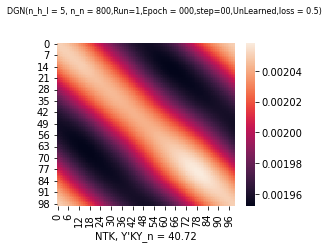

Epoch 1
-------------------------------
Loss over all data : 1.640066 



<Figure size 432x288 with 0 Axes>

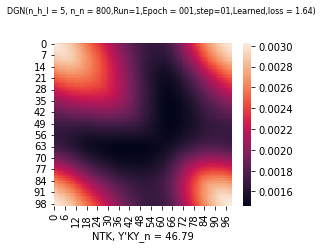

Loss over all data : 4.478739 



<Figure size 432x288 with 0 Axes>

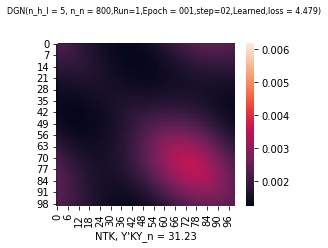

Loss over all data : 108.708015 



<Figure size 432x288 with 0 Axes>

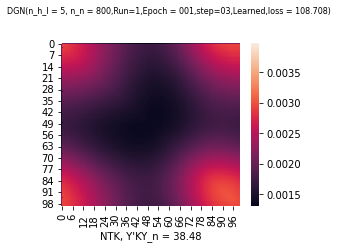

Loss over all data : 0.987654 



<Figure size 432x288 with 0 Axes>

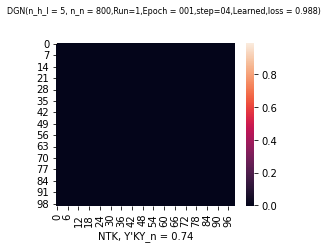

Loss over all data : 0.387272 



<Figure size 432x288 with 0 Axes>

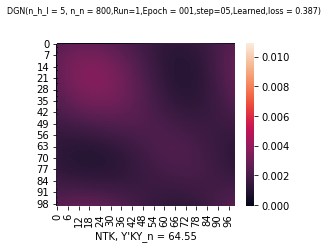

Loss over all data : 0.460891 



<Figure size 432x288 with 0 Axes>

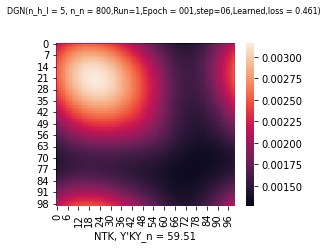

Loss over all data : 2.764129 



<Figure size 432x288 with 0 Axes>

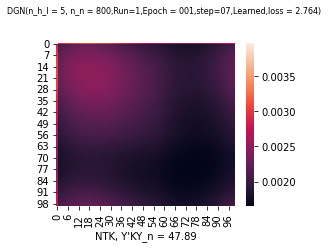

Loss over all data : 2.246896 



<Figure size 432x288 with 0 Axes>

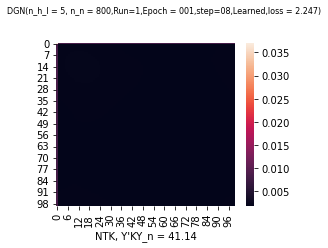

Loss over all data : 1.618782 



<Figure size 432x288 with 0 Axes>

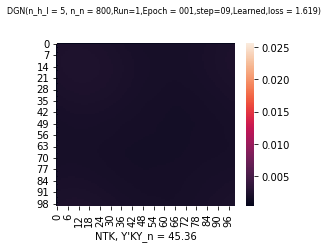

Loss over all data : 6.259040 



<Figure size 432x288 with 0 Axes>

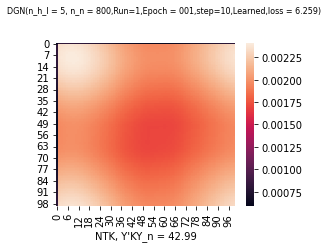

Loss over all data : 0.718127 



<Figure size 432x288 with 0 Axes>

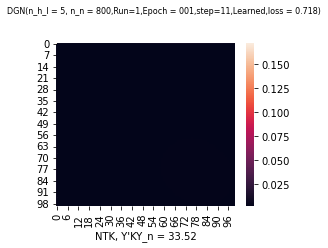

Loss over all data : 4.151412 



<Figure size 432x288 with 0 Axes>

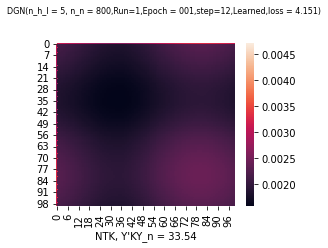

Loss over all data : 1.263730 



<Figure size 432x288 with 0 Axes>

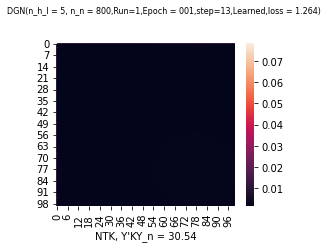

Loss over all data : 0.451189 



<Figure size 432x288 with 0 Axes>

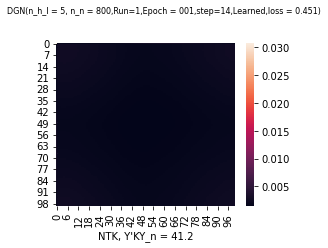

Loss over all data : 0.549993 



<Figure size 432x288 with 0 Axes>

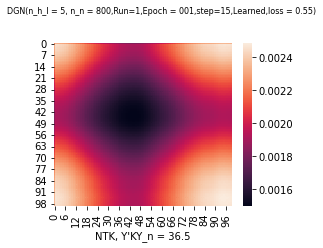

Loss over all data : 0.757518 



<Figure size 432x288 with 0 Axes>

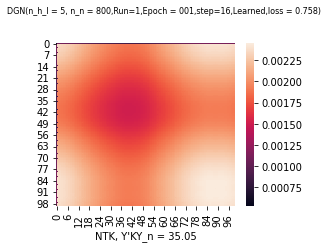

Epoch 2
-------------------------------
Loss over all data : 2.129936 



<Figure size 432x288 with 0 Axes>

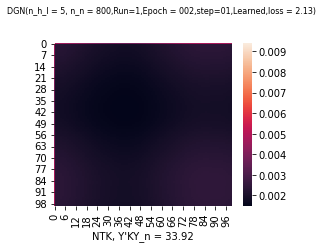

Loss over all data : 0.650338 



<Figure size 432x288 with 0 Axes>

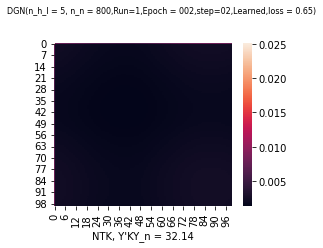

Loss over all data : 1.001343 



<Figure size 432x288 with 0 Axes>

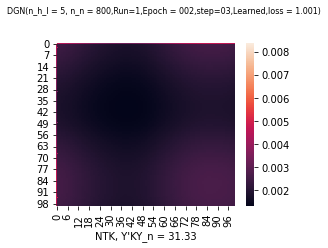

Loss over all data : 1.102996 



<Figure size 432x288 with 0 Axes>

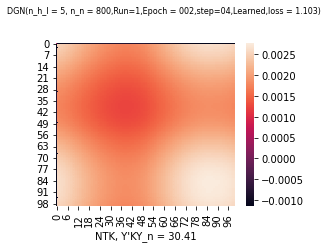

Loss over all data : 0.568087 



<Figure size 432x288 with 0 Axes>

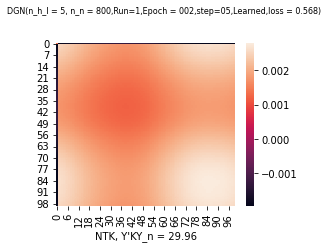

Loss over all data : 1.334043 



<Figure size 432x288 with 0 Axes>

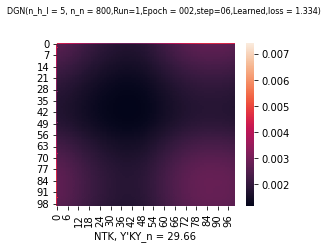

Loss over all data : 0.516493 



<Figure size 432x288 with 0 Axes>

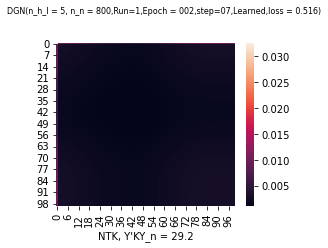

Loss over all data : 0.661891 



<Figure size 432x288 with 0 Axes>

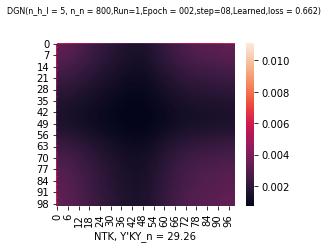

Loss over all data : 0.693355 



<Figure size 432x288 with 0 Axes>

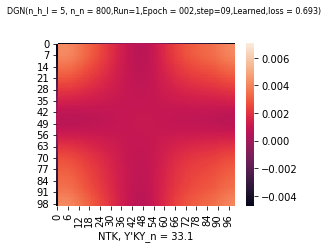

Loss over all data : 0.462633 



<Figure size 432x288 with 0 Axes>

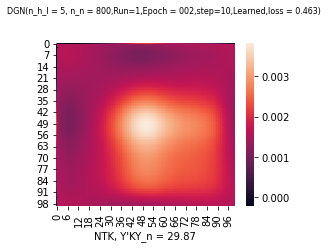

Loss over all data : 0.790546 



<Figure size 432x288 with 0 Axes>

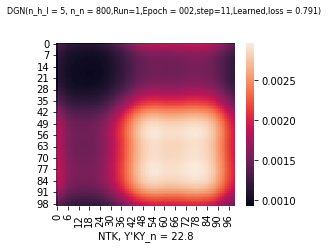

Loss over all data : 0.987276 



<Figure size 432x288 with 0 Axes>

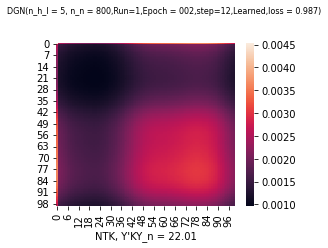

Loss over all data : 0.455794 



<Figure size 432x288 with 0 Axes>

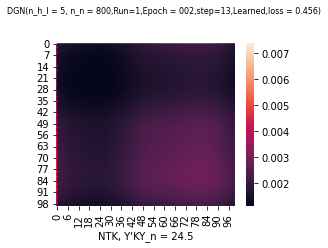

Loss over all data : 0.855454 



<Figure size 432x288 with 0 Axes>

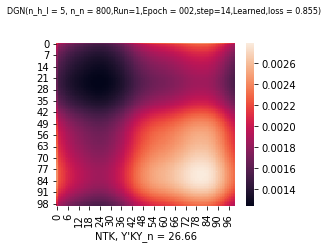

Loss over all data : 0.855816 



<Figure size 432x288 with 0 Axes>

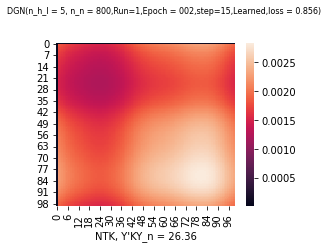

Loss over all data : 0.461585 



<Figure size 432x288 with 0 Axes>

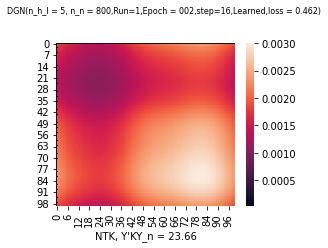

Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Loss over all data : 0.274139 



<Figure size 432x288 with 0 Axes>

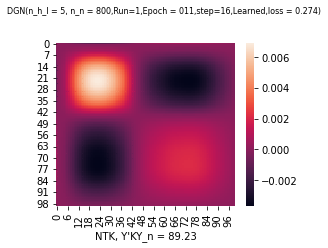

Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Loss over all data : 0.246761 



<Figure size 432x288 with 0 Axes>

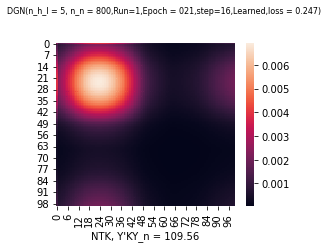

Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
-------------------------------
Epoch 26
-------------------------------
Epoch 27
-------------------------------
Epoch 28
-------------------------------
Epoch 29
-------------------------------
Epoch 30
-------------------------------
Epoch 31
-------------------------------
Loss over all data : 0.253663 



<Figure size 432x288 with 0 Axes>

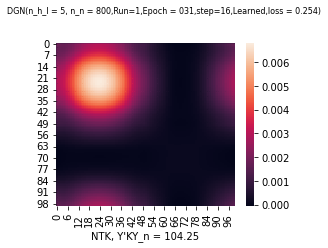

Epoch 32
-------------------------------
Epoch 33
-------------------------------
Epoch 34
-------------------------------
Epoch 35
-------------------------------
Epoch 36
-------------------------------
Epoch 37
-------------------------------
Epoch 38
-------------------------------
Epoch 39
-------------------------------
Epoch 40
-------------------------------
Epoch 41
-------------------------------
Loss over all data : 0.249535 



<Figure size 432x288 with 0 Axes>

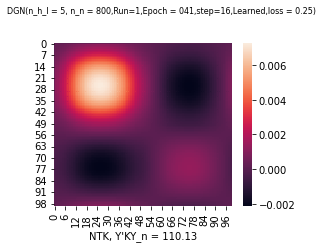

Epoch 42
-------------------------------
Epoch 43
-------------------------------
Epoch 44
-------------------------------
Epoch 45
-------------------------------
Epoch 46
-------------------------------
Epoch 47
-------------------------------
Epoch 48
-------------------------------
Epoch 49
-------------------------------
Epoch 50
-------------------------------
Epoch 51
-------------------------------
Loss over all data : 0.251728 



<Figure size 432x288 with 0 Axes>

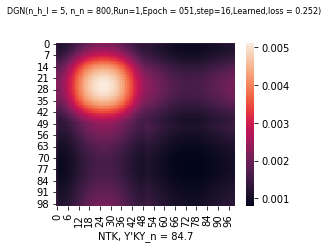

Epoch 52
-------------------------------
Epoch 53
-------------------------------
Epoch 54
-------------------------------
Epoch 55
-------------------------------
Epoch 56
-------------------------------
Epoch 57
-------------------------------
Epoch 58
-------------------------------
Epoch 59
-------------------------------
Epoch 60
-------------------------------
Epoch 61
-------------------------------
Loss over all data : 0.269287 



<Figure size 432x288 with 0 Axes>

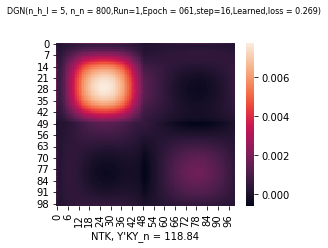

Epoch 62
-------------------------------
Epoch 63
-------------------------------
Epoch 64
-------------------------------
Epoch 65
-------------------------------
Epoch 66
-------------------------------
Epoch 67
-------------------------------
Epoch 68
-------------------------------
Epoch 69
-------------------------------
Epoch 70
-------------------------------
Epoch 71
-------------------------------
Loss over all data : 0.275713 



<Figure size 432x288 with 0 Axes>

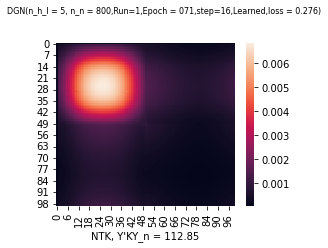

Epoch 72
-------------------------------
Epoch 73
-------------------------------
Epoch 74
-------------------------------
Epoch 75
-------------------------------
Epoch 76
-------------------------------
Epoch 77
-------------------------------
Epoch 78
-------------------------------
Epoch 79
-------------------------------
Epoch 80
-------------------------------
Epoch 81
-------------------------------
Loss over all data : 0.245732 



<Figure size 432x288 with 0 Axes>

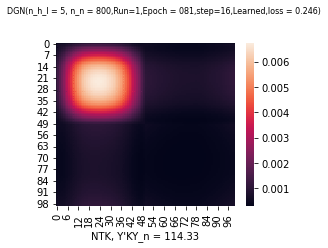

Epoch 82
-------------------------------
Epoch 83
-------------------------------
Epoch 84
-------------------------------
Epoch 85
-------------------------------
Epoch 86
-------------------------------
Epoch 87
-------------------------------
Epoch 88
-------------------------------
Epoch 89
-------------------------------
Epoch 90
-------------------------------
Epoch 91
-------------------------------
Loss over all data : 0.248080 



<Figure size 432x288 with 0 Axes>

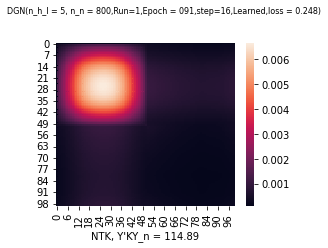

Epoch 92
-------------------------------
Epoch 93
-------------------------------
Epoch 94
-------------------------------
Epoch 95
-------------------------------
Epoch 96
-------------------------------
Epoch 97
-------------------------------
Epoch 98
-------------------------------
Epoch 99
-------------------------------
Epoch 100
-------------------------------
Epoch 101
-------------------------------
Loss over all data : 0.253287 



<Figure size 432x288 with 0 Axes>

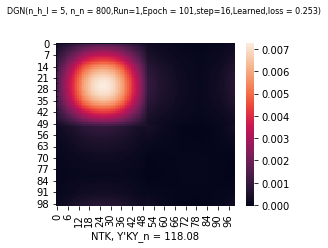

Epoch 102
-------------------------------
Epoch 103
-------------------------------
Epoch 104
-------------------------------
Epoch 105
-------------------------------
Epoch 106
-------------------------------
Epoch 107
-------------------------------
Epoch 108
-------------------------------
Epoch 109
-------------------------------
Epoch 110
-------------------------------


<Figure size 432x288 with 0 Axes>

In [ ]:
'''
 a := Number of half cycles in the top half of the circle
 b := number of half cycles in the bottom half of the circle
 For a, b = 1, 9:
  MLP takes 60 epochs
  DGN takes 130 epochs
  DLGN takes 80 epochs
  DLGN takes 70 epochs
  DLGN takes 70 epochs
'''
n_data_points = 500
a, b = 1, 9
point1_degrees, point2_degrees, diff_in_degrees = 40, 300, 10

X,Y = make_circle_dataset(n_data_points = n_data_points,a = a, b = b, plot = False )
X_sorted, Y_sorted = get_sorted_circle_dataset(X,Y)
train_dataloader, dataloader_all = get_dataloaders(X_sorted, Y_sorted)
dataloader_one = get_stochastic_dataloader(X_sorted, Y_sorted)
x1_idx, x2_idx, x3_idx, x4_idx = get_4_inp_idxs(X_sorted, point1_degrees = point1_degrees, point2_degrees = point2_degrees, diff_in_degrees = diff_in_degrees)
# x1_idx, x2_idx, x3_idx, x4_idx = (56, 70, 417, 431) #value of idxs
# points_idxs = [x1_idx, x2_idx, x3_idx, x4_idx]
# plot_dataset(X_sorted, Y_sorted, points_idxs, save_fig = False)

seed = 0
n_epochs = 110
n_hidden_layers,  n_neurons, n_runs =  5, 800, 1
save_result = True

#Available Protocols : MLP, DGN, DLGN, DLGN-SF, DGN-DLGN-SF
# protocols = ['MLP', "DGN", 'DLGN', 'DLGN-SF','DGN-DLGN-SF']
protocols = ['DGN']
bias = True
for protocol in protocols:
  set_seed(seed = seed)
  if protocol == 'MLP':
    hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, gradients_5_runs = run_mlp_model(train_dataloader=train_dataloader,
                                                                                                      dataloader_all = dataloader_all,
                                                                                                      dataloader_one = dataloader_one,
                                                                                                      n_h_l = n_hidden_layers,
                                                                                                      n_n = n_neurons,
                                                                                                      n_runs = n_runs,
                                                                                                      n_epochs = n_epochs,
                                                                                                      bias = bias)
  else:
    hidden_layer_outs_5_runs, state_info_5_runs, predictions_5_runs, gradients_5_runs = run_npf_npv_model(train_dataloader=train_dataloader,
                                                                                        dataloader_all = dataloader_all,
                                                                                        dataloader_one = dataloader_one,
                                                                                        protocol = protocol,
                                                                                        n_h_l = n_hidden_layers,
                                                                                        n_n = n_neurons,
                                                                                        n_runs = n_runs,
                                                                                        n_epochs = n_epochs)

  # kernel_5_runs = build_neural_tangent_kernels(gradients_5_runs)
  # for kernel_name in ['NTK']:
  #   plot_kernel_values_stepwise(kernel_name,kernel_5_runs )
  #   plot_kernel_values_epochwise(kernel_name,kernel_5_runs )

  # plot_stepwise_activations(hidden_layer_no =2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
  # plot_epochwise_activations(hidden_layer_no = 2, hidden_layer_outs_5_runs = hidden_layer_outs_5_runs)
  # plot_stepwise_loss(state_info_5_runs)
  # plot_epochwise_loss(state_info_5_runs)
  # plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = False)

  # #Saving results of each protocol
  # if save_result:
  #   file_name = f'{protocol}_NTK_5_32_all_epochs_figs'
  #   save_results(file_name)

  #   #Download all protocols result
  #   download_results()

In [ ]:
!zip -r DGN_NTK_npf_npv_5_800_all_epochs.zip /content 

  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/active_config (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2022.02.18/ (stored 0%)
  adding: content/.config/logs/2022.02.18/14.33.12.888636.log (deflated 86%)
  adding: content/.config/logs/2022.02.18/14.33.21.113721.log (deflated 54%)
  adding: content/.config/logs/2022.02.18/14.32.54.268036.log (deflated 53%)
  adding: content/.config/logs/2022.02.18/14.33.40.493787.log (deflated 54%)
  adding: content/.config/logs/2022.02.18/14.32.33.591601.log (deflated 90%)
  adding: content/.config/logs/2022.02.18/14.33.41.267515.log (deflated 53%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/.last_s

In [ ]:
!rm -r *

In [ ]:
plot_kernels(kernel_5_runs, state_info_5_runs,for_all_inputs = True, save_fig = True, show_fig = True)


In [ ]:
#Slider for visulalizing Y_true v/s Y_predicted
preds = [v for x in predictions_5_runs[0] for v in x]
plot_y_prediction(Y_sorted, preds)

In [ ]:
# #Store in pickle file
# temp_dict = {'hidden_layer_outs':hidden_layer_outs_5_runs, 'state_info':state_info_5_runs}
# info = state_info_5_runs[0][0][0]
# fname = f'{info['model_protocol_type']}_{info['n_hidden_layers']}_{info['n_neurons']}_pkl.pkl'
# with open(fname, "wb") as fp:   
#   pickle.dump(temp_dict, fp)


# os.system(f"zip -R {fname}.zip '*.pkl'")
# # !zip -r /content/DGN_DLGN_SF_5_32_all_epochs_pkl.zip /content/DGN_DLGN_SF_5_32_all_epochs_pkl
# files.download(f"{fname}.zip")

In [ ]:
# # !unzip /content/MLP_5_32_all_epochs_pkl.zip 
# with open("/content/content/MLP_5_32_all_epochs_pkl", "rb") as fp:  
#   b = pickle.load(fp)
# kernel_5_runs = b['kernels']
# state_info_5_runs = b['state_info']
# intermediate_outs_5_runs = b['hidden_layer_outs']

----------------------------------------------------------- Commented Old Codes -----------------------------------------------------------

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# #activation for epoch wise for MLP
# def plot_epochwise_activations():
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     temp = []
#     y_label = 'ReLU(x)' if state_info_5_runs[0][0][0]['model_protocol_type'] == 'MLP' else 'ReLU(x)*G(x)'
#     for i in range(5):
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
#           121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
#           134, 135, 136, 137, 138, 139, 140, 141, 142]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

    
#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()
#   #activation for epoch wise for DGN
#   else:
#     temp = []
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))
#     for i in range(5):
#     #   if i ==0:
#     #     temp = np.concatenate(all_intermediate_outs[i], axis = 0)
#     #   else:
#     #     temp += np.concatenate(all_intermediate_outs[i], axis = 0)
#     # temp /= 5
#       # intermediate_outs = np.concatenate(all_intermediate_outs[i], axis = 0)
#       intermediate_outs = np.array(intermediate_outs_5_runs[i])
#       n_steps = [0,15, 30, 45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
#             56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
#             69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,
#             82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
#             95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
#           108, 109, 110, 111, 112, 113, 114, 115, 116]
#       plotx1 = intermediate_outs[n_steps,0]
#       plotx2 = intermediate_outs[n_steps,1]
#       plotx3 = intermediate_outs[n_steps,2]
#       plotx4 = intermediate_outs[n_steps,3]
#       fig = plt.figure(figsize=(30,10))

#       y_label = 'ReLU(x)*G(x)'

#       plt.subplot(2, 2, 1)
#       plt.suptitle('Hidden Layer 2, Run = '+ str(i+1))
#       plt.plot(x,plotx1)
#       plt.title('x1')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
    

#       plt.subplot(2, 2, 2)
#       plt.plot(x, plotx2)
#       plt.title('x2')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 3)
#       plt.plot(x, plotx3)
#       plt.title('x3')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)
#       plt.subplot(2, 2, 4)
#       plt.plot(x, plotx4)
#       plt.title('x4')
#       plt.xlabel('epoch')
#       plt.ylabel(y_label)

#       plt.savefig(f'Run_{i+1}_epoch.png')
#       # plt.plot(plotx1, ax = axes[0])
#       # plt.title('x1')
#       # plt.plot(plotx2, ax = axes[1])
#       # plt.title('x2')
#       # plt.plot(plotx3, ax = axes[2])
#       # plt.title('x3')
#       # plt.plot(plotx4, ax = axes[3])
#       # plt.title('x4')
#     # intermediate_outs = temp
#     plt.show()

In [ ]:
# # For epoch wise loss analysis
# def plot_epochwise_loss():
#   values = []
#   for run in range(len(kernel_5_runs)):
#     for epoch in range(len(kernel_5_runs[run])):
#         loss = state_info_5_runs[run][epoch][-1]['loss']
#         values.append(loss)
        
#         # print(run, epoch)
#         # plot_heatmap(kernel_5_runs[run][epoch][step], state_info_5_runs[run][epoch][step])
      
#   values = np.array(values)

#   #For loss v/s epoch for MLP
#   if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(values[start:start+one_run_len])
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#         axes[run].set_xticks(np.arange(0,one_run_len, 5.0))

#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

#   # For loss v/s epoch for DGN 
#   else:
#     f, axes = plt.subplots(1, 5,figsize = (5*10,10))
#     x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
#     for run in range(5):
#       plt.suptitle('Loss v/s epoch',ha = 'center', fontsize = 30)
#       for i in range(len(values)):
#         one_run_len = int(values.shape[0]/5)
#         start = run*one_run_len
#         axes[run].plot(x, values[start:start+one_run_len])
#         axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
#         axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
#     plt.savefig('loss_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
#     plt.show()

In [ ]:

'''
  # Kernel value graphs epoch wise for MLP
  if state_info_5_runs[0][0][0]['model_protocol_type'] != 'DGN':
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    for run in range(5):
      # plt.figure(figsize = (10,10))
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()

  #Kernel value graphs epoch wise for DGN since it is plotted in interval of 5 after 30 epochs
  else:
    labels = ['x1x1', 'x2x2', 'x3x3', 'x4x4', 'x1x2', 'x3x4']
    f, axes = plt.subplots(5, 1,figsize = (20,7*5))
    x = np.concatenate((np.arange(31), np.arange(31,250,5)))  
    for run in range(5):
      plt.suptitle(f'{kernel_name}_epoch',ha = 'center', fontsize = 30)
      for i in range(len(values)):
        one_run_len = int(values.shape[1]/5)
        start = run*one_run_len
        axes[run].plot(x, values[i][start:start+one_run_len], label=labels[i])
        axes[run].set_xticks(np.arange(min(x), max(x)+1, 10.0))
        axes[run].set_xlabel(f'Run {run+1}', fontsize = 20)
        axes[run].legend(loc='best')

    plt.savefig(f'{kernel_name}_epoch' + ".png" ,format = "png",bbox_inches='tight', dpi = 100)
    plt.show()
'''

In [ ]:
# import numpy as np 
# import plotly.graph_objs as go
# from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# #from  https://stackoverflow.com/questions/47230817/plotly-notebook-mode-with-google-colaboratory
# def configure_plotly_browser_state():
#   import IPython
#   display(IPython.core.display.HTML('''
#         <script src="/static/components/requirejs/require.js"></script>
#         <script>
#           requirejs.config({
#             paths: {
#               base: '/static/base',
#               plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext', 
#             },
#           });
#         </script>
#         '''))


# init_notebook_mode(connected=True)

# #from plotly sliders
# data = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = d.to('cpu').flatten(),
#         #  y =Y_sorted.flatten()
#        ) for d in predictions_run]
# data[10]['visible'] = True

# data2 = [dict(
#         visible = False,
#         line=dict(color='#00CED1', width=2),
#         name = '𝜈 = '+str(step),
#         x = np.arange(0,500,1),
#         y = Y_sorted.flatten(),
#        ) for d in predictions_run]
# data[10]['visible'] = True

# #configure added to visualize in colab
# configure_plotly_browser_state()

# steps = []
# for i in range(len(data)):
#     step = dict(
#         method = 'restyle',  
#         args = ['visible', [False] * len(data)],
#     )
#     step['args'][1][i] = True # Toggle i'th trace to "visible"
#     steps.append(step)

# sliders = [dict(
#     active = 10,
#     currentvalue = {"prefix": "Frequency: "},
#     pad = {"t": 50},
#     steps = steps
# )]

# layout = dict(sliders=sliders)

# fig = dict(data=data, layout=layout)

# fig2 = dict(data=data2, layout=layout)
# configure_plotly_browser_state()


# #removed py. from original plotly code 
# iplot(fig, filename='Sine Wave Slider')
# iplot(fig2, filename='Sine Wave Slider')


In [ ]:
# output = pd.DataFrame(state_info)
# sub_out = pd.DataFrame(list(output[4]))

# sub_out = sub_out.fillna(value='Null')
# cols = sub_out.ne('Null').cumsum(axis=1).idxmax(axis=1)
# K_temp = sub_out.lookup(sub_out.index, cols)

# cols = list(cols)

# for i, row in sub_out.iterrows():
#   sub_out.at[i,cols[i]] = 'Null'
# sub_out.insert(0, 'K', K_temp)

# final_sub_out = sub_out
# final_output = pd.concat([output, final_sub_out], axis = 1, ignore_index=True)


# final_output = final_output.drop([4, final_output.shape[1]-1], 1)
# final_output

#final_output = final_output.drop([4, -1], 1)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8'], axis=1, inplace=False)
# final_output = final_output.set_axis(['protocol', 'n_h_l', 'n_n','Run', 'Status', 'K', 'K1', 'K2', 'K3', 'K4', 'K5'], axis=1, inplace=False)

# final_output.to_csv('final_output.csv')
# files.download("final_output.csv")
# dF1 = pd.read_csv("final_output1.csv")
# dF2 = pd.read_csv("final_output2.csv")
# dF3 = pd.read_csv("final_output3.csv")
# dF4 = pd.read_csv("final_output4.csv")
# dF5 = pd.read_csv("final_output5.csv")
# dF6 = pd.read_csv("final_output6.csv")
# sin10_all_out = pd.concat([dF6, dF1,dF3, dF4,dF5, dF2], axis=0).drop(['Unnamed: 0'], axis = 1)
# dF7 = pd.read_csv("final_output7.csv")
# dF8 = pd.read_csv("final_output8.csv")
# sin4_all_out = pd.concat([dF7, dF8], axis=0).drop(['Unnamed: 0'], axis = 1)
# sin10_all_out.to_csv('sin10_all_output.csv')
# sin4_all_out.to_csv('sin4_all_output.csv')

In [ ]:
# def  get_hyperplanes_params(model, for_layers):
#   layer_weights = []
#   layer_slopes = []
#   layer_intercepts = []
#   for i in range(for_layers):
#     layer_weight = model.layers[i].weight.detach().to("cpu")
#     layer_slope = -(layer_weight[:,0]/layer_weight[:,1])
#     layer_intercept = [0]*32#model.layers[i].bias.detach().to("cpu")

#     layer_weights.append(layer_weight)
#     layer_slopes.append(layer_slope)
#     layer_intercepts.append(layer_intercept)
#   return layer_slopes, layer_intercepts


# def plot_hyperplanes(model, train_status):
  
#   for_layers = len(model.layers)-1
#   layer_slopes, layer_intercepts = get_hyperplanes_params(model, for_layers)
  
  
#   x_axis = np.linspace(start = -2, stop = 2)
#   for i in range(for_layers):
#     plt.figure(figsize = (10,10))
#     #fig, ax = plt.subplots(figsize = (10,10))
#     ax = sns.scatterplot(X_sorted[:,0], X_sorted[:,1], c = prediction.to("cpu"))
#     ax.set_xlim((-2,2))
#     ax.set_ylim((-2,2))
#     for j in range(32):
#       y_axis = layer_slopes[i][j]*x_axis + layer_intercepts[i][j]
#       #plt.plot(x_axis, y_axis)
#       sns.lineplot(x = x_axis, y = y_axis)
#     plt.title(train_status+" Layer_"+str(i+1))
#     plt.savefig(train_status+" Layer_"+str(i+1))
#     plt.show()

#     plot_hyperplanes(npf_model, model_protocol_type+" "+model_learning_status)